## Ch1. The Machine Learning Landscape
이번 Chapter에서는 간단한 Machine Learning의 Flow에 대하여 살펴보자.  

기본적으로 필요한 Library들은 <code>pip install -r requirements.txt</code>로서 설치할 수 있다.  

#### 필요한 Library Import

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import urllib


import os
import sys

import numpy as np
import pandas as pd
import sklearn
import sklearn.linear_model
from sklearn import preprocessing
from sklearn import pipeline

import tensorflow as tf

# Matplotlib Setting
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#### Library Version Check

In [2]:
# Python ≥3.5 is required
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
assert sklearn.__version__ >= "0.20"

# Tensorflow Version check
print(tf.__version__)

2.0.1


### Preprocessing
이미지를 저장하기 위한 Function과 Directory를 생성한다.  
이번 Chapter와 앞으로의 Chapter에서도 Dataset을 Visualization하거나 결과를 확인하기 위해서 이다.  
또한 항상 같은 결과를 내기 위하여 Random의 Seed또한 고정한다.

In [3]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "fundamentals"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
np.random.seed(42)

### Dataset
기본적으로 이번 Chapter에서 사용하는 Dataset을 Download받고 확인하는 작업이다.  

사용하는 Dataset은 <a href="https://github.com/ageron/handson-ml2">Handson-ml2</a>에서 Download받거나 아래 Code를 통하여 Download받는다.

In [4]:
# Dataset Path
datapath = os.path.join("datasets", "lifesat", "")

# Download the Dataset
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
os.makedirs(datapath, exist_ok=True)
for filename in ("oecd_bli_2015.csv", "gdp_per_capita.csv"):
    print("Downloading", filename)
    url = DOWNLOAD_ROOT + "datasets/lifesat/" + filename
    urllib.request.urlretrieve(url, datapath + filename)

### Preprocessing Data
실제 사용하기 위한 2개의 Dataset을 하나로 합치고 Model에 알맞는 Dataset으로서 변형하는 단계이다.  
각각의 Dataset에 대한 Preprocessing의 과정이 다르다.  

**def prepare_country_stats(oecd_bli, gdp_per_capita)**  
Argument: oecd_bli, gdp_per_capita  
Output: full_country_stats  

- oecd_bli_2015.csv: 현재 Dataset은 각가의 나라에 대하여 Feature에 따라 Value의 Type이 다르다.
 - TOT 의 Type을 가진 Value만 뽑아 낸다.
 - County는 Index, Column은 Feature(Indicator)로서 변형한다.
 
- gdb_per_capita: 각가의 나라에 대하여 GDP per capita와 이를 어떤 단위로 표현하였는지 나타낸다.
 - 2015 -> GDP per capita로서 Column을 변형한다.
 - Index를 Country로서 변형한다.
 
- full_country_stats: 하나의 Dataset으로서 합친다. 다양한 Feature와 서로다른 GDP를 보유한 Dataest으로서 나타나게 된다. (36x30)
 - 몇몇 Indicies를 제외하게 된다. 아마 Model의 결과를 증가시키기 위하여 Outlier를 제거하는 것으로 보인다.
 - 최종적으로 GDP per capita, Life satisfaction의 Column만 가져오게 된다. 즉, GDP per capita가 Life satisfaction에 영향을 미치는지 알아보기 위해서 이러한 과정을 거치게 된다.
 

In [5]:
def prepare_country_stats(oecd_bli, gdp_per_capita):
    oecd_bli = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"]
    oecd_bli = oecd_bli.pivot(index="Country", columns="Indicator", values="Value")
    gdp_per_capita.rename(columns={"2015": "GDP per capita"}, inplace=True)
    gdp_per_capita.set_index("Country", inplace=True)
    full_country_stats = pd.merge(left=oecd_bli, right=gdp_per_capita,
                                  left_index=True, right_index=True)
    full_country_stats.sort_values(by="GDP per capita", inplace=True)
    remove_indices = [0, 1, 6, 8, 33, 34, 35]
    keep_indices = list(set(range(36)) - set(remove_indices))
    
    return full_country_stats[["GDP per capita", 'Life satisfaction']].iloc[keep_indices], full_country_stats[["GDP per capita", 'Life satisfaction']].iloc[remove_indices]

### Checking dtat
실제 사용하는 Dataset(oecd_bil_2015.csv, gdp_per_capitia.csv)를 활용하여 Preprocessing 과정을 거친 뒤, Data의 형태가 어떠한지 살펴보자.

Saving figure money_happy_scatterplot


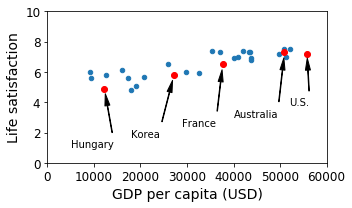

In [6]:
# Load the data
oecd_bli = pd.read_csv(datapath + "oecd_bli_2015.csv", thousands=',')
gdp_per_capita = pd.read_csv(datapath + "gdp_per_capita.csv",thousands=',',delimiter='\t',
                             encoding='latin1', na_values="n/a")

# Prepare the data
sample_data, missing_data = prepare_country_stats(oecd_bli, gdp_per_capita)

# Visualization Data
sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(5,3))
plt.axis([0, 60000, 0, 10])
position_text = {
    "Hungary": (5000, 1),
    "Korea": (18000, 1.7),
    "France": (29000, 2.4),
    "Australia": (40000, 3.0),
    "United States": (52000, 3.8),
}
for country, pos_text in position_text.items():
    pos_data_x, pos_data_y = sample_data.loc[country]
    country = "U.S." if country == "United States" else country
    plt.annotate(country, xy=(pos_data_x, pos_data_y), xytext=pos_text,
            arrowprops=dict(facecolor='black', width=0.5, shrink=0.1, headwidth=5))
    plt.plot(pos_data_x, pos_data_y, "ro")
plt.xlabel("GDP per capita (USD)")
save_fig('money_happy_scatterplot')
plt.show()

In [7]:
# Save the Dataet
sample_data.to_csv(os.path.join("datasets", "lifesat", "lifesat.csv"))

# Check the Dataset
sample_data.loc[list(position_text.keys())]

,GDP per capita,Life satisfaction
Country,,
Hungary,12239.894,4.9
Korea,27195.197,5.8
France,37675.006,6.5
Australia,50961.865,7.3
United States,55805.204,7.2


### Linear Regression(No Train)
위의 Dataset을 살펴보게 되면 GDP per catita (USD)가 증가함에 따라서 Life satisfaction이 Linear하게 증가되는 것을 확인할 수 있다.  

Sklearn을 사용하여 Linear Regression Model을 생성하는 것이 아닌 임의의 Parameter로서 Linear Regression을 Visualization하여 확인하여 보자.

Saving figure tweaking_model_params_plot


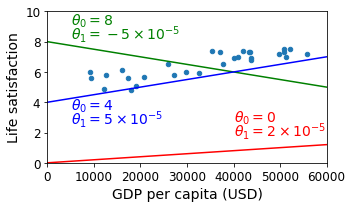

In [8]:
sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(5,3))
plt.xlabel("GDP per capita (USD)")
plt.axis([0, 60000, 0, 10])
X=np.linspace(0, 60000, 1000)
plt.plot(X, 2*X/100000, "r")
plt.text(40000, 2.7, r"$\theta_0 = 0$", fontsize=14, color="r")
plt.text(40000, 1.8, r"$\theta_1 = 2 \times 10^{-5}$", fontsize=14, color="r")
plt.plot(X, 8 - 5*X/100000, "g")
plt.text(5000, 9.1, r"$\theta_0 = 8$", fontsize=14, color="g")
plt.text(5000, 8.2, r"$\theta_1 = -5 \times 10^{-5}$", fontsize=14, color="g")
plt.plot(X, 4 + 5*X/100000, "b")
plt.text(5000, 3.5, r"$\theta_0 = 4$", fontsize=14, color="b")
plt.text(5000, 2.6, r"$\theta_1 = 5 \times 10^{-5}$", fontsize=14, color="b")
save_fig('tweaking_model_params_plot')
plt.show()

### Simple Linear Regression
<code>sklearn.linear_model</code>을 활용하여 간단한 <span>$y(\text{Life satisfaction}) = \theta_1(\text{GDP per capita}) * x + \theta_0$</span>을 만들고 결과를 확인한다.

Saving figure best_fit_model_plot


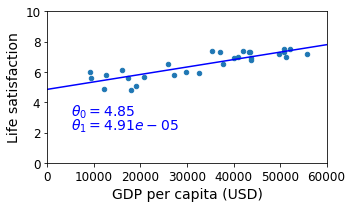

In [9]:
# Dataset
X = np.c_[sample_data["GDP per capita"]]
y = np.c_[sample_data["Life satisfaction"]]

# Select a linear model
model = sklearn.linear_model.LinearRegression()

# Train the model
model.fit(X, y)

# Get Slope and Bias
t0, t1 = model.intercept_[0], model.coef_[0][0]

# Visualization Linear Regression
sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(5,3))
plt.xlabel("GDP per capita (USD)")
plt.axis([0, 60000, 0, 10])
X=np.linspace(0, 60000, 1000)
plt.plot(X, t0 + t1*X, "b")
plt.text(5000, 3.1, r"$\theta_0 = %.2f$"%t0, fontsize=14, color="b")
plt.text(5000, 2.2, r"$\theta_1 = %.2e$"%t1, fontsize=14, color="b")
save_fig('best_fit_model_plot')
plt.show()

### Prediction Data
실제 Train에 사용되지 않고 제외되었던 Data를 활용하여 Model의 Prediction값과 실제 값의 차이를 Visualization하여 알아보자.

In [10]:
missing_data

,GDP per capita,Life satisfaction
Country,,
Brazil,8669.998,7.0
Mexico,9009.280,6.7
Chile,13340.905,6.7
Czech Republic,17256.918,6.5
Norway,74822.106,7.4
Switzerland,80675.308,7.5
Luxembourg,101994.093,6.9


위의 Dataset은 Train에서 제외되었던 Data들이다. Training된 Model은 어떠한 값을 예측하는지 알아보자.

Saving figure prediction_model_plot


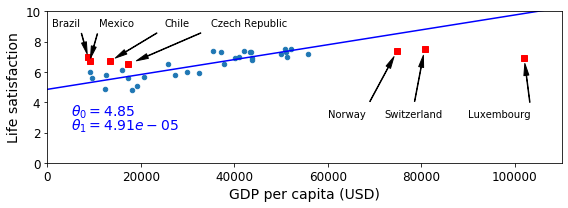

In [11]:
# Missing Data -> Dict
position_text2 = {
    "Brazil": (1000, 9.0),
    "Mexico": (11000, 9.0),
    "Chile": (25000, 9.0),
    "Czech Republic": (35000, 9.0),
    "Norway": (60000, 3),
    "Switzerland": (72000, 3.0),
    "Luxembourg": (90000, 3.0),
}

# Visualization Linear Regression
sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(8,3))
plt.xlabel("GDP per capita (USD)")
plt.axis([0, 110000, 0, 10])

# Real Data
for country, pos_text in position_text2.items():
    pos_data_x, pos_data_y = missing_data.loc[country]
    plt.annotate(country, xy=(pos_data_x, pos_data_y), xytext=pos_text,
            arrowprops=dict(facecolor='black', width=0.5, shrink=0.1, headwidth=5))
    plt.plot(pos_data_x, pos_data_y, "rs")


X=np.linspace(0, 110000, 1000)
plt.plot(X, t0 + t1*X, "b")
plt.text(5000, 3.1, r"$\theta_0 = %.2f$"%t0, fontsize=14, color="b")
plt.text(5000, 2.2, r"$\theta_1 = %.2e$"%t1, fontsize=14, color="b")
save_fig('prediction_model_plot')
plt.show()

### ReTrain The Model
Data의 수가 적은 이유 때문에 실제 Training된 Model은 새로운 값들에 대하여 예측을 잘 못하는 경향을 보여주고 있다.  
새로운 Dataset을 포함하여 Model을 Retrain시키고, 결과를 확인하여 보자.

Saving figure representative_training_data_scatterplot


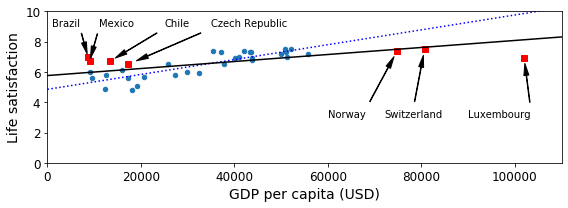

In [12]:
full_country_stats = pd.concat([sample_data,missing_data])
sample_data.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(8,3))
plt.axis([0, 110000, 0, 10])

for country, pos_text in position_text2.items():
    pos_data_x, pos_data_y = missing_data.loc[country]
    plt.annotate(country, xy=(pos_data_x, pos_data_y), xytext=pos_text,
            arrowprops=dict(facecolor='black', width=0.5, shrink=0.1, headwidth=5))
    plt.plot(pos_data_x, pos_data_y, "rs")

X=np.linspace(0, 110000, 1000)
plt.plot(X, t0 + t1*X, "b:")

lin_reg_full = sklearn.linear_model.LinearRegression()
Xfull = np.c_[full_country_stats["GDP per capita"]]
yfull = np.c_[full_country_stats["Life satisfaction"]]
lin_reg_full.fit(Xfull, yfull)

t0full, t1full = lin_reg_full.intercept_[0], lin_reg_full.coef_[0][0]
X = np.linspace(0, 110000, 1000)
plt.plot(X, t0full + t1full * X, "k")
plt.xlabel("GDP per capita (USD)")

save_fig('representative_training_data_scatterplot')
plt.show()

### Machine Learning Key Challenge
Machine Learning을 잘 Training하여 Prediction하기 위한 몇몇 중요한 과제들이 있다.  

1. 많은 양의 Dataset이 필요하다. Training을 위해서는 많은 양의 Dataset이 필요하게 되며, 많은 Dataet을 포함시킬 수록 Generalization된 Model이라고 말할 수 있다. 각각의 Model의 특성에 따라서 필요로 하는 Dataset의 양은 달라지게 된다.

2. 대표성이 없는 훈련 데이터. 위의 과정에서 실제 Model을 Retrain하여야지 잘 Prediction할 수 있는 것을 확인하였다. 이러한 문제는 대표성이 없는 Dataset으로서 학습하였기 때문이다. 즉 Sorting된 36개의 Sample중 제외한 Index는 <code>[0, 1, 6, 8, 33, 34, 35]</code>이므로 매우 가난하거나 매우 부유한 곳에서의 Model의 Prediction은 결과가 매우 다른것을 확인할 수 있었다.  
 1) Sampling Noise: 샘플이 작으면 우연에 의하ㅏㄴ 대표성 없는 데이터가 생긴다.  
 2) Sampling Bias: 매우 큰 샘플도 표본 추출 방법이 잘못되면 대표성을 띠지 못할 수 있다.  

3. 낮은 품질의 데이터: Training데이터가 Error나 Outlier를 많이 포함하게 되면 Pattern을 찾기 힘들 것 이다. Preprocessing과정에서 이러한 Outlier를 제거하거나 Normalization을 통하여 줄여주는 작업이 필요하다.

4. 관련없는 특성: Model을 Training한다는 것은 결국 Dataset에서의 Pattern을 찾는다는 의미이다. 이러한 과정에서 의미없는 Feature로서 Model을 Training하게 되면, Training결과도 좋지 않고 당연한 결과로서 Prediction도 정확하지 않은 Model이 될 것이다. 따라서 사용자에게 Feature Selection과 Feature Extraction이 매우 중요한 과정으로서 남게 된다.

5. <a href="https://wjddyd66.github.io/dl/NeuralNetwork-(5)-Others/#%EC%98%A4%EB%B2%84%ED%94%BC%ED%8C%85%EA%B3%BC-%EC%96%B8%ED%84%B0%ED%94%BC%ED%8C%85">Overfitting, Underfitting</a>: Model을 다룰 때 매우 중요한 요소중 하나이다. Model의 Training정도와 Generalization을 위하여 꼭 확인해야 할 요소이다. 이번 Post에서는 양이 많아서 다루지 않는다. 궁금하신 분들은 링크를 참조하자.

Example) Overfitting 예시

c:\users\admin\workspace\pythonsetting\handson\lib\site-packages\numpy\lib\nanfunctions.py:1545: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)
c:\users\admin\workspace\pythonsetting\handson\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Saving figure overfitting_model_plot


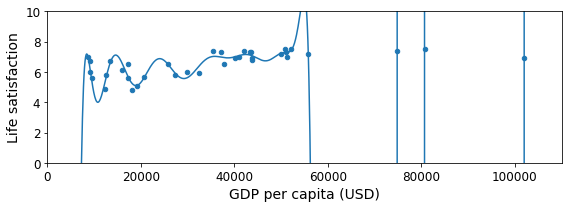

In [13]:
full_country_stats.plot(kind='scatter', x="GDP per capita", y='Life satisfaction', figsize=(8,3))
plt.axis([0, 110000, 0, 10])

poly = preprocessing.PolynomialFeatures(degree=60, include_bias=False)
scaler = preprocessing.StandardScaler()
lin_reg2 = sklearn.linear_model.LinearRegression()

pipeline_reg = pipeline.Pipeline([('poly', poly), ('scal', scaler), ('lin', lin_reg2)])
pipeline_reg.fit(Xfull, yfull)
curve = pipeline_reg.predict(X[:, np.newaxis])
plt.plot(X, curve)
plt.xlabel("GDP per capita (USD)")
save_fig('overfitting_model_plot')
plt.show()

#### Regularization
위의 Model은 Overfitting된 Model이다.  
다양한 Overfitting방지 방법이 있지만 여기에서는 L2 Regularization인 <code>linear_model.Ridge(alpha=10**9.5)</code>를 사용하였다.  
<a href="https://wjddyd66.github.io/dl/NeuralNetwork-(5)-Others/#%EC%98%A4%EB%B2%84%ED%94%BC%ED%8C%85%EA%B3%BC-%EC%96%B8%ED%84%B0%ED%94%BC%ED%8C%85">Regularization</a>에 대한 자세한 내용은 링크를 참조하자.

Saving figure ridge_model_plot


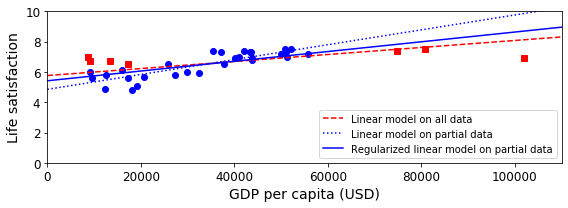

In [14]:
plt.figure(figsize=(8,3))

plt.xlabel("GDP per capita")
plt.ylabel('Life satisfaction')

plt.plot(list(sample_data["GDP per capita"]), list(sample_data["Life satisfaction"]), "bo")
plt.plot(list(missing_data["GDP per capita"]), list(missing_data["Life satisfaction"]), "rs")

X = np.linspace(0, 110000, 1000)
plt.plot(X, t0full + t1full * X, "r--", label="Linear model on all data")
plt.plot(X, t0 + t1*X, "b:", label="Linear model on partial data")

ridge = sklearn.linear_model.Ridge(alpha=10**9.5)
Xsample = np.c_[sample_data["GDP per capita"]]
ysample = np.c_[sample_data["Life satisfaction"]]
ridge.fit(Xsample, ysample)
t0ridge, t1ridge = ridge.intercept_[0], ridge.coef_[0][0]
plt.plot(X, t0ridge + t1ridge * X, "b", label="Regularized linear model on partial data")

plt.legend(loc="lower right")
plt.axis([0, 110000, 0, 10])
plt.xlabel("GDP per capita (USD)")
save_fig('ridge_model_plot')
plt.show()